<a href="https://colab.research.google.com/github/lilythomson13/finalproject/blob/main/Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 3001 Final Project Results
### Alysha Akhtar & Lily Thomson

## Import dependencies and data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
import random
import warnings

In [5]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv')

<ipython-input-5-902b012e865a>:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('METABRIC_RNA_Mutation.csv')


In [6]:
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1,Positve,...,0,0,0,0,0,0,0,0,0,0


## Set predictor and response variables for simple model

In [47]:
df = df[['overall_survival_months', 'age_at_diagnosis', 'tumor_size', 'mutation_count', 'brca2', 'cdh1', 'er_status', 'pr_status', 'her2_status']]
df = df.dropna()

y = df['overall_survival_months']

X_num = df[['age_at_diagnosis', 'tumor_size', 'mutation_count', 'brca2', 'cdh1']]
X_num.loc[:, ['age_at_diagnosis', 'tumor_size', 'mutation_count']] = \
    X_num[['age_at_diagnosis', 'tumor_size', 'mutation_count']].apply(zscore)

X_dummies_er = pd.get_dummies(df['er_status'], dtype = 'int').rename(columns=lambda x: f'ER_{x}')
X_dummies_pr = pd.get_dummies(df['pr_status'], dtype = 'int').rename(columns=lambda x: f'PR_{x}')
X_dummies_her2 = pd.get_dummies(df['her2_status'], dtype = 'int').rename(columns=lambda x: f'HER2_{x}')
X = pd.concat([X_num, X_dummies_er, X_dummies_pr, X_dummies_her2], axis = 1)

<ipython-input-47-66090356e788>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_num.loc[:, ['age_at_diagnosis', 'tumor_size', 'mutation_count']] = \


In [48]:
y.head()

,overall_survival_months
1,84.633333
2,163.700000
3,164.933333
4,41.366667
5,7.800000


In [49]:
X.head()

,age_at_diagnosis,tumor_size,mutation_count,brca2,cdh1,ER_Negative,ER_Positive,PR_Negative,PR_Positive,HER2_Negative,HER2_Positive
1,-1.379202,-1.073910,-0.994757,0.2777,1.3594,0,1,0,1,1,0
2,-0.941783,-0.744699,-0.994757,-0.8426,1.1398,0,1,0,1,1,0
3,-1.033425,-0.086277,-1.266216,-0.5428,1.2491,0,1,0,1,1,0
4,1.222211,0.901355,-0.994757,-0.9039,0.9131,0,1,0,1,1,0
5,1.360830,0.308776,-0.451840,0.6931,1.1520,0,1,0,1,1,0


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

In [51]:
X_train

,age_at_diagnosis,tumor_size,mutation_count,brca2,cdh1,ER_Negative,ER_Positive,PR_Negative,PR_Positive,HER2_Negative,HER2_Positive
328,-0.287964,-0.744699,-1.266216,-0.6789,0.4888,0,1,0,1,1,0
994,0.814055,0.901355,0.362535,0.9789,-0.1384,0,1,1,0,1,0
327,-0.271792,0.374618,-1.266216,-0.4845,0.6431,0,1,0,1,1,0
1488,0.311177,-0.415488,-0.723299,0.0020,-0.0450,0,1,0,1,1,0
925,-0.856301,1.230566,0.633994,0.6936,0.4725,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
65,1.870639,-0.283804,0.362535,-1.8070,-2.4652,0,1,1,0,1,0
386,0.053192,-0.415488,0.905452,-0.0268,-0.2269,0,1,0,1,1,0
92,1.912995,1.164724,-0.723299,0.9146,-1.0493,0,1,0,1,1,0
840,0.931881,2.349884,0.091077,0.9728,-0.1632,0,1,1,0,1,0


## Cross Validation to select number of components

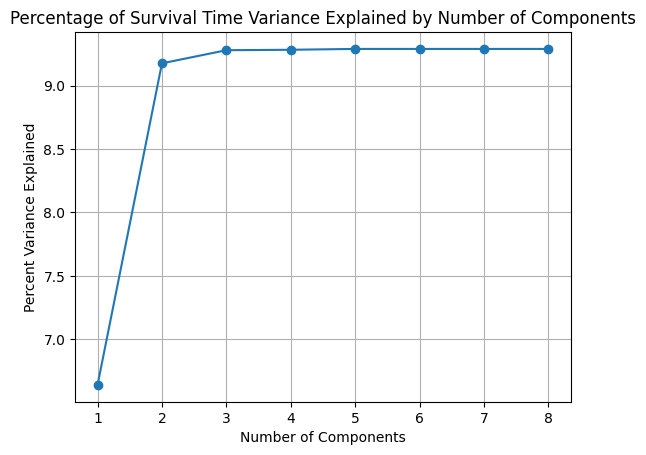

In [53]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt

perc_var = []
x = range(1, 9)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n_components in x:
    pls = PLSRegression(n_components=n_components)

    mse_scores = cross_val_score(pls, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    avg_mse = -np.mean(mse_scores)

    variance_y = np.var(y_train, ddof=1)
    perc_var_explained = 100 * (1 - avg_mse / variance_y)

    perc_var.append(perc_var_explained)

plt.plot(x, perc_var, marker='o')
plt.xticks(x)
plt.grid()
plt.title("Percentage of Survival Time Variance Explained by Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Percent Variance Explained")
plt.show()
